In [1]:
import os
import numpy as np
import librosa
import torch
import laion_clap
import pandas as pd
from tqdm import tqdm
import gc
import subprocess
import tempfile

torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Функции для квантования
def int16_to_float32(x):
    return (x / 32767.0).astype(np.float32)

def float32_to_int16(x):
    x = np.clip(x, a_min=-1., a_max=1.)
    return (x * 32767.).astype(np.int16)

# Функция для рекурсивного поиска всех аудиофайлов в папке
def get_all_audio_files(directory, file_extensions=['.wav', '.mp3', '.flac', '.m4a']):
    audio_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in file_extensions):
                audio_files.append(os.path.join(root, file))
    return audio_files

# Функция для получения эмбеддинга аудио с использованием модели CLAP
def get_audio_embedding(file_path, model):
    audio_data = None
    temp_wav = None
    try:
        # Если файл имеет формат .m4a, конвертируем его во временный .wav
        if file_path.lower().endswith('.m4a'):
            temp_wav = tempfile.NamedTemporaryFile(suffix='.wav', delete=False).name
            subprocess.call(['ffmpeg', '-i', file_path, '-y', temp_wav],
                            stdout=subprocess.DEVNULL,
                            stderr=subprocess.DEVNULL)
            file_to_load = temp_wav
        else:
            file_to_load = file_path

        # Загружаем аудио с помощью librosa
        audio_data, _ = librosa.load(file_to_load, sr=44000)
        audio_data = audio_data.reshape(1, -1)
        audio_data = torch.from_numpy(audio_data).float()

        # Получаем эмбеддинг
        audio_embed = model.get_audio_embedding_from_data(x=audio_data, use_tensor=True)
        audio_embed = audio_embed.cpu().numpy()
        return audio_embed

    except Exception as e:
        print(f"Ошибка при обработке {file_path}:")
        print(f"Тип ошибки: {type(e).__name__}")
        print(f"Детали ошибки: {str(e)}")
        print("--------------------")
        return None
    finally:
        if audio_data is not None:
            del audio_data
        if temp_wav and os.path.exists(temp_wav):
            os.unlink(temp_wav)
        torch.cuda.empty_cache()
        gc.collect()

# Функция для загрузки и парсинга эмбеддингов из safetensors файла
def load_embeddings(output_file):
    from safetensors.torch import load_file, safe_open
    # Загружаем тензоры
    embeddings = load_file(output_file, device="cpu")
    # Получаем метаданные (пути к файлам)
    with safe_open(output_file, framework="pt") as f:
        metadata = f.metadata()

    data = []
    for key, tensor in embeddings.items():
        file_path = metadata.get(key, None)
        # Если tensor является torch.Tensor, приводим его к numpy
        embedding = tensor.numpy() if isinstance(tensor, torch.Tensor) else tensor
        data.append((file_path, embedding))
    df = pd.DataFrame(data, columns=["file_path", "embedding"])
    return df

# Основная функция для обработки аудиофайлов, сохранения эмбеддингов в safetensors 
# и загрузки уже существующих эмбеддингов, если файл существует
def process_audio_files(directory, output_file, checkpoint_path):
    # Если файл с эмбеддингами уже существует, загружаем его
    existing_embeddings = {}
    if os.path.exists(output_file):
        print("Загружаем существующие эмбеддинги из safetensors файла...")
        df_existing = load_embeddings(output_file)
        existing_embeddings = dict(zip(df_existing['file_path'], df_existing['embedding']))
        print(f"Загружено {len(existing_embeddings)} существующих эмбеддингов.")

    # Инициализация модели CLAP
    model = laion_clap.CLAP_Module(enable_fusion=False, amodel='HTSAT-base')
    model.load_ckpt(checkpoint_path)

    # Получаем все аудиофайлы из указанной директории
    audio_files = get_all_audio_files(directory)
    
    # Фильтруем только новые файлы (которые ещё не обработаны)
    new_files = [f for f in audio_files if f not in existing_embeddings]
    print(f"Найдено {len(new_files)} новых файлов для обработки.")

    # Список для хранения эмбеддингов, начинаем с уже существующих
    data = list(existing_embeddings.items())

    # Обрабатываем новые файлы
    for audio_file in tqdm(new_files):
        with torch.no_grad():
            audio_embed = get_audio_embedding(audio_file, model)
        if audio_embed is not None:
            data.append((audio_file, audio_embed))

    # Подготовка данных для safetensors: формируем словари для тензоров и метаданных
    from safetensors.torch import save_file
    embedding_dict = {}
    metadata = {}
    for i, (file_path, embedding) in enumerate(data):
        key = f"embedding_{i}"
        tensor_embedding = torch.tensor(embedding) if not torch.is_tensor(embedding) else embedding
        embedding_dict[key] = tensor_embedding
        metadata[key] = file_path

    # Сохраняем данные в safetensors файл
    save_file(embedding_dict, output_file, metadata=metadata)
    print(f"Эмбеддинги сохранены в {output_file}, всего записей: {len(data)}")

if __name__ == '__main__':
    # Укажите путь к контрольной точке модели
    checkpoint_path = 'music_speech_epoch_15_esc_89.25.pt'  # Путь к вашему чекпоинту
    # Укажите директорию с аудиофайлами для обработки
    deep_cloned_directory = '/media/amg/NeuroSDD/projects/massive_voice_cloner/4.Testing_datasets (clean) (copy)'
    # Укажите имя выходного файла с расширением .safetensors
    output_file_deep_cloned = 'Voices_Distance_emb.safetensors'
    process_audio_files(deep_cloned_directory, output_file_deep_cloned, checkpoint_path)


/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexi

Load the specified checkpoint music_speech_epoch_15_esc_89.25.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.w

100%|███████████████████████████████████████████████████████████████████████████████| 265/265 [01:29<00:00,  2.98it/s]

Эмбеддинги сохранены в Voices_Distance_emb.safetensors, всего записей: 265


In [11]:
# import os
# import json
# import pandas as pd
# import torch
# from safetensors.torch import save_file

# # Загружаем DataFrame из pickle-файла
# pickle_file = "Voices_Distance_emb.pkl"
# df = pd.read_pickle(pickle_file)
# print(f"DataFrame загружен из {pickle_file}. Количество записей: {len(df)}")

# # Подготавливаем данные для safetensors
# tensor_dict = {}
# meta_dict = {}

# # Для каждой строки DataFrame создаём ключ и сохраняем эмбеддинг как тензор,
# # остальные данные (например, file_path и дополнительные столбцы) сохраняем в метаданных.
# for i, row in df.iterrows():
#     key = f"row_{i}"
#     embedding = row['embedding']
#     # Приводим эмбеддинг к torch.Tensor, если он ещё не в этом формате
#     if not torch.is_tensor(embedding):
#         embedding = torch.tensor(embedding)
#     tensor_dict[key] = embedding
    
#     # Формируем метаданные для записи
#     metadata_entry = {}
#     for col in df.columns:
#         if col != 'embedding':  # исключаем сам эмбеддинг, так как он уже сохранён
#             metadata_entry[col] = row[col]
#     meta_dict[key] = json.dumps(metadata_entry)

# # Указываем имя выходного safetensors файла (рекомендуется использовать расширение .safetensors)
# output_file = "Voices_Distance_emb_from_pickle.safetensors"

# # Сохраняем данные в формате safetensors
# save_file(tensor_dict, output_file, metadata=meta_dict)
# print(f"Данные успешно сохранены в {output_file}")


DataFrame загружен из Voices_Distance_emb.pkl. Количество записей: 265
Данные успешно сохранены в Voices_Distance_emb_from_pickle.safetensors


In [1]:
import os
import numpy as np
import librosa
import torch
import laion_clap
import pandas as pd
from tqdm import tqdm
import gc

deep_cloned_directory = '/media/amg/NeuroSDD/projects/massive_voice_cloner/4.Testing_datasets (clean) (copy)'

/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
import pandas as pd
import torch
from safetensors.torch import load_file, safe_open

def load_embeddings_as_dataframe(safetensor_file):
    # Загружаем словарь тензоров из safetensors файла
    embeddings = load_file(safetensor_file, device="cpu")
    
    # Получаем метаданные (пути к файлам)
    with safe_open(safetensor_file, framework="pt") as f:
        metadata = f.metadata()
    
    data = []
    for key, tensor in embeddings.items():
        # Получаем путь к файлу из метаданных
        file_path = metadata.get(key, None)
        # Приводим тензор к numpy массиву
        embedding_np = tensor.numpy() if isinstance(tensor, torch.Tensor) else tensor
        data.append((file_path, embedding_np))
    
    # Создаём DataFrame с колонками file_path и embedding
    df = pd.DataFrame(data, columns=["file_path", "embedding"])
    return df


safetensor_file = "Voices_Distance_emb.safetensors"
df = load_embeddings_as_dataframe(safetensor_file)
print(df.head())


                                           file_path  \
0  {"file_path": "/media/amg/NeuroSDD/projects/ma...   
1  {"file_path": "/media/amg/NeuroSDD/projects/ma...   
2  {"file_path": "/media/amg/NeuroSDD/projects/ma...   
3  {"file_path": "/media/amg/NeuroSDD/projects/ma...   
4  {"file_path": "/media/amg/NeuroSDD/projects/ma...   

                                           embedding  
0  [[-0.09331409, 0.017413966, -0.019353198, 0.04...  
1  [[-0.0490579, 0.013195926, -0.09222824, -0.017...  
2  [[-0.089611486, 0.04686182, -0.05908038, 0.002...  
3  [[-0.049555216, 0.006063638, -0.015762527, 0.0...  
4  [[-0.07582835, 0.041426312, -0.02442208, 0.084...  


In [3]:
df

,file_path,embedding
0,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.09331409, 0.017413966, -0.019353198, 0.04..."
1,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.0490579, 0.013195926, -0.09222824, -0.017..."
2,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.089611486, 0.04686182, -0.05908038, 0.002..."
3,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.049555216, 0.006063638, -0.015762527, 0.0..."
4,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.07582835, 0.041426312, -0.02442208, 0.084..."
...,...,...
260,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.03967145, 0.057510056, -0.07532253, 0.024..."
261,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[0.011041801, -0.015112647, -0.0572534, 0.025..."
262,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.09353557, 0.07889329, -0.06010835, 0.0270..."
263,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.09231813, 0.05819913, -0.07105919, 0.0239..."


In [4]:
dirs = os.listdir(deep_cloned_directory)


def extract_name(path):
    # Пример: извлечение имени из последнего элемента пути, предполагаемого формата 'V1-Melissa-30s.m4a'
    return path.split('/')[-1]  # Это может потребовать адаптации

def standardize_method(path, directories):
    # Сортируем директории по длине (от длинных к коротким)
    dirs_sorted = sorted(directories, key=len, reverse=True)
    
    for d in dirs_sorted:
        if d in path:
            return d
    return "unknown"

# Применение функций к DataFrame
df['name'] = df['file_path'].apply(extract_name)
df['method'] = df['file_path'].apply(lambda p: standardize_method(p, dirs))


# df.to_pickle("Voices_Distance_emb_ext_method.pkl")

# Вывод обновленного DataFrame
df.head(50)


,file_path,embedding,name,method
0,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.09331409, 0.017413966, -0.019353198, 0.04...","V12-Voice.wav""}",Eleven Labs
1,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.0490579, 0.013195926, -0.09222824, -0.017...","V17-Voice.wav""}",Eleven Labs
2,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.089611486, 0.04686182, -0.05908038, 0.002...","V11-Voice.wav""}",Eleven Labs
3,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.049555216, 0.006063638, -0.015762527, 0.0...","V15-Voice.wav""}",fish_speech
4,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.07582835, 0.041426312, -0.02442208, 0.084...","V5-Voice.wav""}",fish_speech
5,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.06644801, 0.0327723, -0.022313952, 0.0343...","V10-Voice.wav""}",fish_speech
6,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.09919763, -0.006715403, -0.015740214, 0.0...","V12-Voice.wav""}",30s_orig_speech
7,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.0848179, 0.034618244, -0.0660101, -0.0465...","V17-Voice.wav""}",30s_orig_speech
8,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.041974686, 0.05166875, -0.060556103, 0.03...","V14-Voice.wav""}",30s_orig_speech
9,"{""file_path"": ""/media/amg/NeuroSDD/projects/ma...","[[-0.06101225, 0.039417308, -0.05242183, 0.039...","V4-Voice.wav""}",30s_orig_speech


In [5]:
df['method'].nunique()
df['method'].unique()

df.index.is_unique 



True

In [6]:
df.columns.is_unique

True

In [7]:

# Проверка наличия необходимых столбцов
if 'name' in df.columns and 'method' in df.columns:
    grouped = df.groupby(['name', 'method'])
    voice_embeddings = {}
    for (name, method), group in grouped:
        mean_embedding = np.mean(np.vstack(group['embedding'].apply(lambda x: np.array(x).squeeze())), axis=0)
        if name not in voice_embeddings:
            voice_embeddings[name] = {}
        voice_embeddings[name][method] = mean_embedding

    # Расчет расстояний
    distances = {}
    for name, methods in voice_embeddings.items():
        if '30s_orig_speech' in methods:
            original_embedding = methods['30s_orig_speech']
            distances[name] = {}
            for method, embedding in methods.items():
                if method != '30s_orig_speech':
                    distance = np.linalg.norm(original_embedding - embedding)
                    distances[name][method] = distance
else:
    print("Ошибка: В DataFrame отсутствуют необходимые столбцы 'name' или 'method'")


In [8]:
distances

{'V1-Voice.wav"}': {'Eleven Labs': 0.67692715,
  'XTTS(STS)': 1.0049723,
  'XTTS(STS)_audio_sr': 0.95954216,
  'XTTS(TTS)': 1.0193963,
  'XTTS(TTS)_audio_sr': 0.73610044,
  'Zonos-v0.1-hybrid': 1.0646869,
  'Zonos-v0.1-transformer': 1.0879219,
  'f5_cloned': 0.533352,
  'f5_cloned_sr': 0.6708253,
  'f5_cloned_voicefix': 0.91014415,
  'fish_speech': 0.7348938,
  'you_tts': 0.9025742,
  'you_tts_sr': 0.8914505,
  'you_tts_voicefix': 1.0483209},
 'V10-Voice.wav"}': {'Eleven Labs': 0.8259603,
  'XTTS(STS)': 1.3277485,
  'XTTS(STS)_audio_sr': 0.96872807,
  'XTTS(TTS)': 0.8251221,
  'XTTS(TTS)_audio_sr': 0.8584185,
  'Zonos-v0.1-hybrid': 1.196242,
  'Zonos-v0.1-transformer': 0.9425841,
  'f5_cloned': 0.770657,
  'f5_cloned_sr': 0.87664324,
  'f5_cloned_voicefix': 0.8758348,
  'fish_speech': 0.8704413,
  'you_tts': 0.994614,
  'you_tts_sr': 1.0544784,
  'you_tts_voicefix': 1.087034},
 'V11-Voice.wav"}': {'Eleven Labs': 0.63029253,
  'XTTS(STS)': 1.1717848,
  'XTTS(STS)_audio_sr': 0.976369,
  

Визуализация эмбедингов один голос 

2025-03-09 02:49:57.420762: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-09 02:49:57.451280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 02:49:58.083529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_st

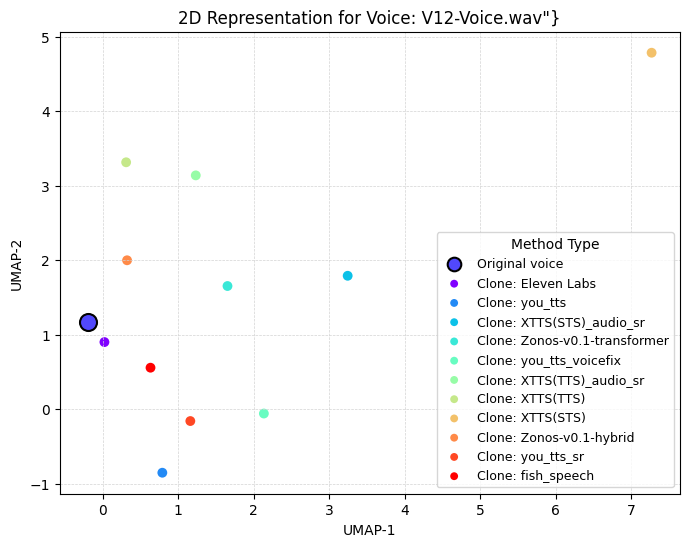

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import pathlib

# Функция для сокращения пути к файлу до последних n частей (по умолчанию 2)
def get_last_parts(path_str, n=2):
    if not path_str:
        return None
    parts = pathlib.Path(path_str).parts
    return '/'.join(parts[-n:])  # например, "dir2/dir3/file.wav"

# -----------------------------
# Предполагается, что существует DataFrame df со столбцами:
#   df['name']      : имя владельца голоса (строка)
#   df['method']    : '30s_orig_speech' для оригинала или иной метод для клона
#   df['embedding'] : numpy-массив или список чисел (вектор эмбеддинга)
#   df['file_path'] : полный путь к файлу
# Также имеется словарь distances, где distances[name][method] = расстояние до оригинала
# -----------------------------

# 1) Собираем все эмбеддинги в единый массив
embeddings = np.vstack(df['embedding'].values)

# 2) Снижаем размерность с помощью UMAP до 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# 3) Формируем DataFrame для визуализации с координатами x, y и дополнительной информацией
df_plot = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_plot['name'] = df['name']
df_plot['method'] = df['method']
df_plot['file_path'] = df.get('file_path', None)
df_plot['short_file'] = df_plot['file_path'].apply(get_last_parts)

# 4) Фильтруем данные для одного выбранного голоса (например, первого из уникальных)
selected_voice = df_plot['name'].unique()[0]
df_voice = df_plot[df_plot['name'] == selected_voice].copy()

# Определяем оригинальный метод
original_method = '30s_orig_speech'

# 5) Подготавливаем colormap, чтобы каждой точке назначить уникальный цвет
N = len(df_voice)
cmap = plt.cm.get_cmap('rainbow', N)

plt.figure(figsize=(8, 6))
ax = plt.gca()

# Используем множество для отслеживания уже добавленных методов в легенду
seen_methods = set()

# 6) Рисуем каждую точку индивидуально с уникальным цветом
for j, (_, row) in enumerate(df_voice.iterrows()):
    x, y = row['x'], row['y']
    method = row['method']
    color = cmap(j)
    # Если точка относится к оригинальному голосу, делаем её крупнее с окантовкой
    if method == original_method:
        marker_size = 150
        edgecolors = 'k'
        linewidths = 1.5
    else:
        marker_size = 50
        edgecolors = 'none'
        linewidths = 0

    # Добавляем легенду только для первого вхождения метода
    if method not in seen_methods:
        if method == original_method:
            label = "Original voice"
        else:
            label = f"Clone: {method}"
        seen_methods.add(method)
    else:
        label = None

    plt.scatter(x, y, color=color, s=marker_size,
                edgecolors=edgecolors, linewidths=linewidths, label=label)

# Удаляем аннотацию выноской (оставляем оригинальную точку выделенной)
# Теперь в легенде оригинальный голос будет отображаться, и его запись стоит первой.

# 7) Получаем текущие объекты легенды и переупорядочиваем так, чтобы "Original voice" был первым
handles, labels = ax.get_legend_handles_labels()
if "Original voice" in labels:
    idx = labels.index("Original voice")
    # Извлекаем оригинальный голос
    orig_handle = handles.pop(idx)
    orig_label = labels.pop(idx)
    # Вставляем его первым
    handles.insert(0, orig_handle)
    labels.insert(0, orig_label)

ax.legend(handles, labels, title='Method Type', loc='best', fontsize=9, markerscale=0.8)

# Настройка подписей осей и заголовка
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title(f'2D Representation for Voice: {selected_voice}')

# Настраиваем сетку и фон
plt.grid(True, color='lightgrey', linestyle='--', linewidth=0.5)
ax.set_facecolor('white')

# Отображаем диаграмму в Jupyter Notebook
plt.show()


Визуализация всех эмбедингов 3d

In [10]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import umap
import pathlib

# Допустим, есть DataFrame df со столбцами:
#   df['name']      : чей голос (строка)
#   df['method']    : '30s_orig_speech' или другой метод
#   df['embedding'] : np-массив или список float
#   df['file_path'] : полный путь к файлу
# Также есть словарь distances[name][method] = расстояние до оригинала

# --------------------------------------------
# Функция, чтобы оставить последние 3 части пути
def get_last_parts(path_str, n=2):
    if not path_str:
        return None
    parts = pathlib.Path(path_str).parts
    return '/'.join(parts[-n:])  # например, "dir2/dir3/file.wav"

# 1) Собираем все эмбеддинги в массив
embeddings = np.vstack(df['embedding'].values)

# 2) Снижаем размерность UMAP до 3D
reducer = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = reducer.fit_transform(embeddings)

# 3) Создаём df_plot со столбцами x,y,z,name,method, и сокращённым путём
df_plot = pd.DataFrame(embeddings_3d, columns=['x','y','z'])
df_plot['name']     = df['name']
df_plot['method']   = df['method']
df_plot['file_path'] = df.get('file_path', None)

# Сокращаем путь к файлу до последних 3 частей
df_plot['short_file'] = df_plot['file_path'].apply(get_last_parts)

# 4) Создаём пустую фигуру
fig = go.Figure()

# Подберём палитру для «клонов»
palette = px.colors.qualitative.Plotly  # ["#636EFA","#EF553B", ...]
unique_names = df_plot['name'].unique()

for i, name_val in enumerate(unique_names):
    # Отбираем все точки этого голоса
    sub = df_plot[df_plot['name'] == name_val].copy()

    # Цвет для «клонированных» методов
    clone_color = palette[i % len(palette)]

    # Готовим массив цветов и hover-текстов
    color_array = []
    hover_texts = []

    for idx, row in sub.iterrows():
        method_val = row['method']
        # Пытаемся получить расстояние из словаря distances
        dist_val = None
        if name_val in distances and method_val in distances[name_val]:
            dist_val = distances[name_val][method_val]

        # Если это оригинал, ставим бирюзовый, иначе clone_color
        if method_val == '30s_orig_speech':
            color_array.append('#00ffff')  # бирюзовый
        else:
            color_array.append(clone_color)

        # Сформируем текст для всплывающей подсказки
        hover_texts.append(
            f"name={row['name']}"
            f"<br>method={method_val}"
            f"<br>distance={dist_val if dist_val is not None else 'N/A'}"
            f"<br>file={row['short_file']}"
        )

    # Добавляем один трейс на весь голос (name_val),
    # внутри которого разные точки окрашены в разные цвета
    fig.add_trace(
        go.Scatter3d(
            x=sub['x'],
            y=sub['y'],
            z=sub['z'],
            mode='markers',
            marker=dict(size=5, color=color_array),
            name=name_val,  # для легенды
            text=hover_texts,
            hoverinfo='text'
        )
    )

# 5) Настраиваем внешний вид (тёмный фон, оси, шрифты)
fig.update_layout(
    title='Voices_3D_representation ',
    scene=dict(
        xaxis_title='UMAP-1',
        yaxis_title='UMAP-2',
        zaxis_title='UMAP-3',
        bgcolor='black',
        xaxis=dict(gridcolor='#444', showbackground=True, backgroundcolor='black'),
        yaxis=dict(gridcolor='#444', showbackground=True, backgroundcolor='black'),
        zaxis=dict(gridcolor='#444', showbackground=True, backgroundcolor='black'),
    ),
    paper_bgcolor='black',
    font=dict(color='white')
)

# 6) Сохраняем интерактивную визуализацию
fig.write_html("audio_embeddings_visualization.html")
print("Визуализация сохранена в audio_embeddings_visualization.html")


/home/amg/miniconda3/envs/music/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Визуализация сохранена в audio_embeddings_visualization.html


Сравнение только методов клонирования

In [11]:
import pandas as pd
import numpy as np

# Создание DataFrame из словаря distances
final_df = pd.DataFrame.from_dict(distances, orient='index')

# Извлечение уникального имени (например, 'V1', 'V10' и т.д.) из индекса
final_df['Person'] = final_df.index.map(lambda x: x.split('-')[0] if '-' in x else x)
final_df.set_index('Person', inplace=True)

# Удаляем столбцы, если в их названии встречаются слова "sr" или "voicefix"
filtered_columns = [col for col in final_df.columns 
                    if ('sr' not in col.lower()) and ('voicefix' not in col.lower())]
filtered_df = final_df[filtered_columns]

# Функция для подсветки минимального значения
def highlight_min(data, color='green'):
    attr = f'font-weight: bold; background-color: {color}'
    if data.ndim == 1:  # Применяем только по строкам
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:
        is_min = data == data.min(axis=1)[:, None]
        return pd.DataFrame(np.where(is_min, attr, ''), index=data.index, columns=data.columns)

# Применение стилизации к отфильтрованному DataFrame
styled_filtered_df = filtered_df.style.apply(highlight_min, axis=1)
styled_filtered_df


,Eleven Labs,XTTS(STS),XTTS(TTS),Zonos-v0.1-hybrid,Zonos-v0.1-transformer,f5_cloned,fish_speech,you_tts
Person,,,,,,,,
V1,0.676927,1.004972,1.019396,1.064687,1.087922,0.533352,0.734894,0.902574
V10,0.825960,1.327749,0.825122,1.196242,0.942584,0.770657,0.870441,0.994614
V11,0.630293,1.171785,0.964712,0.923060,0.843111,0.710551,0.720102,0.956030
V12,0.559970,1.417847,0.800698,1.020333,0.967308,nan,0.749728,0.966569
V13,0.580348,1.261888,0.888314,1.083563,0.990605,0.781940,0.784969,1.090365
V14,0.498614,1.439890,1.157674,0.944049,0.869178,0.681463,0.796760,1.101545
V15,0.638046,0.835701,0.936388,1.145196,1.234826,0.707207,0.809884,1.073578
V17,0.782560,1.009821,1.026760,1.018015,0.919575,0.835432,0.892588,0.866165
V19,0.555416,1.299254,0.874814,0.829510,0.881289,0.508323,0.741075,0.946892


Сравнение инструментов улучшения качества аудио audiosr voicefix

In [12]:
import pandas as pd
import numpy as np

# Предположим, что final_df уже создан
final_df = pd.DataFrame.from_dict(distances, orient='index')


# Извлечение уникального имени (например, 'V1', 'V10' и т.д.) из индекса
final_df['Person'] = final_df.index.map(lambda x: x.split('-')[0] if '-' in x else x)
final_df.set_index('Person', inplace=True)

# 1. Все столбцы, оканчивающиеся на _sr или _voicefix
suffix_cols = [col for col in final_df.columns 
               if col.endswith('_sr') or col.endswith('_voicefix')]

# 2. «Базовые» имена (убираем суффикс)
base_names = {col.rsplit('_', 1)[0] for col in suffix_cols}

# 3. Находим «базовые» столбцы, совпадающие по имени
base_cols = [col for col in final_df.columns if col in base_names]

# 4. Три дополнительные колонки (проверяем, что они действительно есть)
additional_cols = [c for c in ["XTTS(STS)", "Eleven Labs", "XTTS(TTS)"] 
                   if c in final_df.columns]

# 5. Формируем итоговый список, сохраняя порядок, как в исходном DataFrame
selected_cols = []
for col in final_df.columns:
    if (col in suffix_cols) or (col in base_cols) or (col in additional_cols):
        selected_cols.append(col)

# Итоговый фрейм только с нужными столбцами
final_selected_df = final_df[selected_cols]

# Функция для подсветки минимального значения в строке
def highlight_min(data, color='green'):
    attr = f'font-weight: bold; background-color: {color}'
    if data.ndim == 1:
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:
        is_min = data == data.min(axis=1)[:, None]
        return pd.DataFrame(np.where(is_min, attr, ''), index=data.index, columns=data.columns)

# Применяем стилизацию (подсветку минимальных значений)
styled_df = final_selected_df.style.apply(highlight_min, axis=1)

styled_df


,Eleven Labs,XTTS(STS),XTTS(STS)_audio_sr,XTTS(TTS),XTTS(TTS)_audio_sr,f5_cloned,f5_cloned_sr,f5_cloned_voicefix,you_tts,you_tts_sr,you_tts_voicefix
Person,,,,,,,,,,,
V1,0.676927,1.004972,0.959542,1.019396,0.736100,0.533352,0.670825,0.910144,0.902574,0.891451,1.048321
V10,0.825960,1.327749,0.968728,0.825122,0.858419,0.770657,0.876643,0.875835,0.994614,1.054478,1.087034
V11,0.630293,1.171785,0.976369,0.964712,0.877273,0.710551,0.821617,0.776259,0.956030,0.860200,0.848093
V12,0.559970,1.417847,0.877899,0.800698,1.104254,nan,nan,nan,0.966569,0.834570,0.995035
V13,0.580348,1.261888,0.990933,0.888314,0.689803,0.781940,0.827366,0.966826,1.090365,1.010588,1.105197
V14,0.498614,1.439890,1.098887,1.157674,1.180496,0.681463,0.814698,0.944718,1.101545,1.069191,1.042612
V15,0.638046,0.835701,0.817084,0.936388,0.752323,0.707207,0.640499,0.798132,1.073578,1.025018,1.148869
V17,0.782560,1.009821,0.958295,1.026760,0.976686,0.835432,0.879100,0.960263,0.866165,0.928520,0.985767
V19,0.555416,1.299254,0.863492,0.874814,0.774285,0.508323,0.543032,0.880632,0.946892,0.760451,0.871140
